# ML Project : NYC Yellow taxi price prediction

Across New York City, thousands of people step into yellow taxis every day, relying on them to navigate the busy streets quickly and efficiently. Yet the final fare can vary widely from one trip to another, depending on a mix of geographic, temporal, and environmental conditions. With this in mind, our goal is to investigate whether we can use available data and predictive modeling techniques to estimate taxi fares more accurately, ultimately providing insights that could benefit both riders and drivers.

We will be using the following dataset to make train our model : https://www.kaggle.com/datasets/elemento/nyc-yellow-taxi-trip-data

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random

import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.ensemble import VotingClassifier
from sklearn.pipeline import make_pipeline


from sklearn.ensemble import BaggingClassifier
from sklearn.datasets import make_classification

from sklearn.cluster import MiniBatchKMeans
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import time

# Step 1: Data overview

In [6]:
# import dataset
df = pd.read_csv(r'yellow_tripdata_2015-01.csv')
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,2,2015-01-15 19:05:39,2015-01-15 19:23:42,1,1.59,-73.993896,40.750111,1,N,-73.974785,40.750618,1,12.0,1.0,0.5,3.25,0.0,0.3,17.05
1,1,2015-01-10 20:33:38,2015-01-10 20:53:28,1,3.30,-74.001648,40.724243,1,N,-73.994415,40.759109,1,14.5,0.5,0.5,2.00,0.0,0.3,17.80
2,1,2015-01-10 20:33:38,2015-01-10 20:43:41,1,1.80,-73.963341,40.802788,1,N,-73.951820,40.824413,2,9.5,0.5,0.5,0.00,0.0,0.3,10.80
3,1,2015-01-10 20:33:39,2015-01-10 20:35:31,1,0.50,-74.009087,40.713818,1,N,-74.004326,40.719986,2,3.5,0.5,0.5,0.00,0.0,0.3,4.80
4,1,2015-01-10 20:33:39,2015-01-10 20:52:58,1,3.00,-73.971176,40.762428,1,N,-74.004181,40.742653,2,15.0,0.5,0.5,0.00,0.0,0.3,16.30


In [7]:
# Quick overview of distribution of the numerical values
df.describe()

,VendorID,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
count,1.274899e+07,1.274899e+07,1.274899e+07,1.274899e+07,1.274899e+07,1.274899e+07,1.274899e+07,1.274899e+07,1.274899e+07,1.274899e+07,1.274899e+07,1.274899e+07,1.274899e+07,1.274899e+07,1.274898e+07,1.274899e+07
mean,1.521437e+00,1.681491e+00,1.345913e+01,-7.256184e+01,3.997282e+01,1.036901e+00,-7.260904e+01,3.999961e+01,1.386712e+00,1.190566e+01,3.082790e-01,4.977986e-01,1.853814e+00,2.434984e-01,2.831431e-01,1.510829e+01
std,4.995402e-01,1.337924e+00,9.844094e+03,1.012510e+01,5.578691e+00,6.732240e-01,9.966037e+00,5.487742e+00,4.988611e-01,1.030254e+01,5.916643e-01,3.534229e-02,1.106432e+03,1.527171e+00,6.908633e-02,1.106503e+03
min,1.000000e+00,0.000000e+00,0.000000e+00,-1.219258e+02,0.000000e+00,1.000000e+00,-7.401667e+02,-9.029157e+00,1.000000e+00,-4.500000e+02,-7.900000e+01,-5.000000e-01,-9.242000e+01,-2.600000e+01,0.000000e+00,-4.503000e+02
25%,1.000000e+00,1.000000e+00,1.000000e+00,-7.399168e+01,4.073554e+01,1.000000e+00,-7.399120e+01,4.073436e+01,1.000000e+00,6.500000e+00,0.000000e+00,5.000000e-01,0.000000e+00,0.000000e+00,3.000000e-01,8.160000e+00
50%,2.000000e+00,1.000000e+00,1.680000e+00,-7.398160e+01,4.075314e+01,1.000000e+00,-7.397976e+01,4.075362e+01,1.000000e+00,9.000000e+00,0.000000e+00,5.000000e-01,1.000000e+00,0.000000e+00,3.000000e-01,1.116000e+01
75%,2.000000e+00,2.000000e+00,3.000000e+00,-7.396662e+01,4.076757e+01,1.000000e+00,-7.396246e+01,4.076880e+01,2.000000e+00,1.350000e+01,5.000000e-01,5.000000e-01,2.060000e+00,0.000000e+00,3.000000e-01,1.630000e+01
max,2.000000e+00,9.000000e+00,1.542000e+07,7.866265e+01,4.047000e+02,9.900000e+01,8.527402e+01,4.595333e+02,5.000000e+00,4.008000e+03,9.999900e+02,5.000000e-01,3.950589e+06,1.450090e+03,3.000000e-01,3.950612e+06


In [8]:
# Check info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12748986 entries, 0 to 12748985
Data columns (total 19 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   VendorID               int64  
 1   tpep_pickup_datetime   object 
 2   tpep_dropoff_datetime  object 
 3   passenger_count        int64  
 4   trip_distance          float64
 5   pickup_longitude       float64
 6   pickup_latitude        float64
 7   RateCodeID             int64  
 8   store_and_fwd_flag     object 
 9   dropoff_longitude      float64
 10  dropoff_latitude       float64
 11  payment_type           int64  
 12  fare_amount            float64
 13  extra                  float64
 14  mta_tax                float64
 15  tip_amount             float64
 16  tolls_amount           float64
 17  improvement_surcharge  float64
 18  total_amount           float64
dtypes: float64(12), int64(4), object(3)
memory usage: 1.8+ GB


In [9]:
# Check for missing values
df.isna().sum().sort_values(ascending=False)

improvement_surcharge    3
VendorID                 0
dropoff_latitude         0
tolls_amount             0
tip_amount               0
mta_tax                  0
extra                    0
fare_amount              0
payment_type             0
dropoff_longitude        0
tpep_pickup_datetime     0
store_and_fwd_flag       0
RateCodeID               0
pickup_latitude          0
pickup_longitude         0
trip_distance            0
passenger_count          0
tpep_dropoff_datetime    0
total_amount             0
dtype: int64

# Step 2: Data Visualisation 

## 2.1) Univariate analysis
We want a quick overview of the distributions of the numerical

In [12]:
# Make a numerical and categorical columns list
univariate_analysis_values=[]
geographical_values=[]

geo_cols = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']
numerical_values = [x for x in df.columns if df[x].dtypes != object]

for x in numerical_values:
    if x in geo_cols:
        geographical_values.append(x)
    else:
        univariate_analysis_values.append(x)


In [13]:
random.seed(42)
rows = df.sample(n=50000)

<Figure size 1000x600 with 0 Axes>

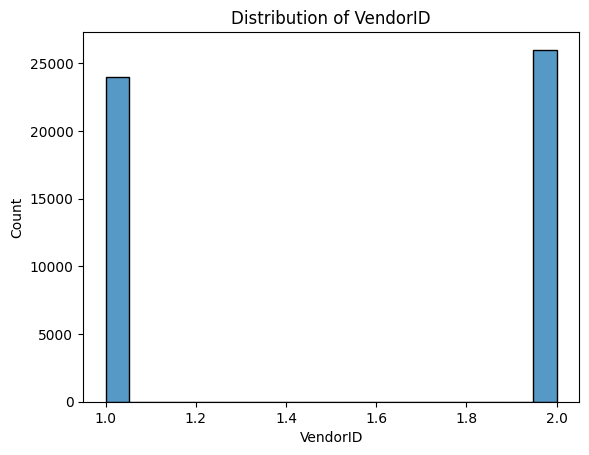

<Figure size 1000x600 with 0 Axes>

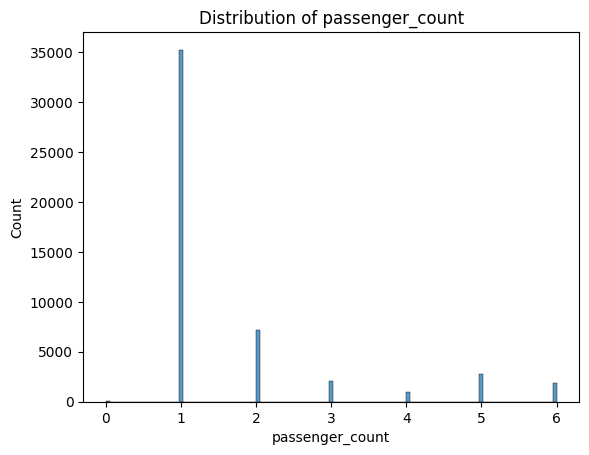

<Figure size 1000x600 with 0 Axes>

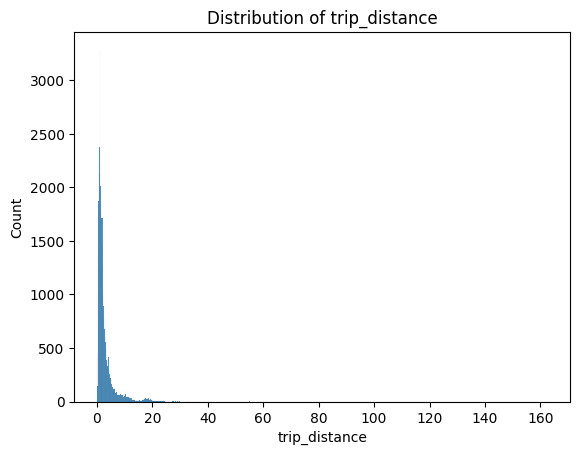

<Figure size 1000x600 with 0 Axes>

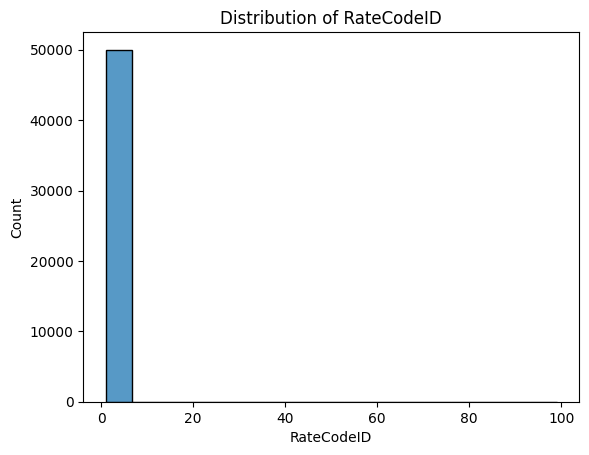

<Figure size 1000x600 with 0 Axes>

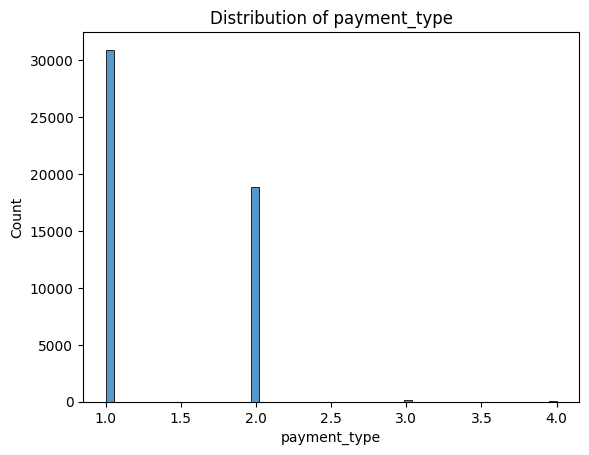

<Figure size 1000x600 with 0 Axes>

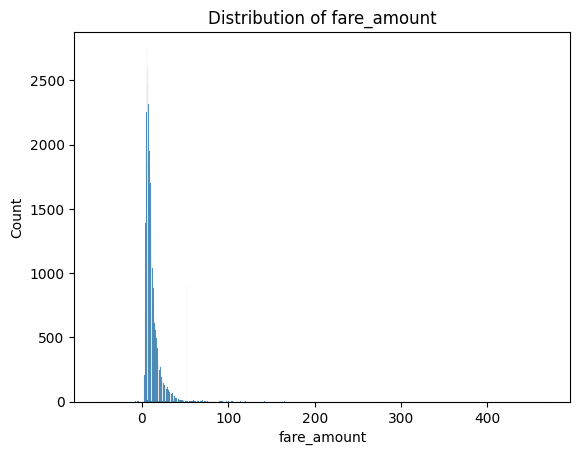

<Figure size 1000x600 with 0 Axes>

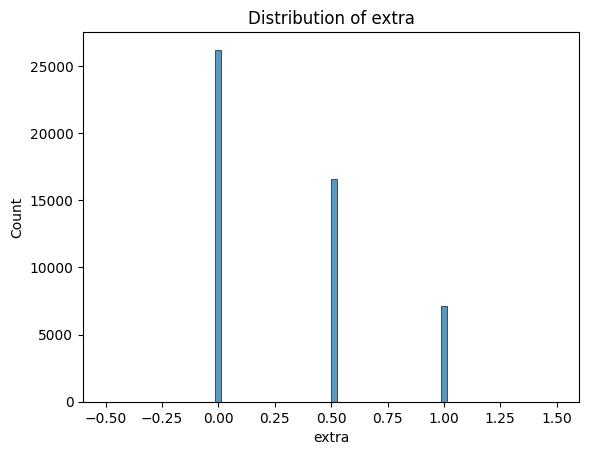

<Figure size 1000x600 with 0 Axes>

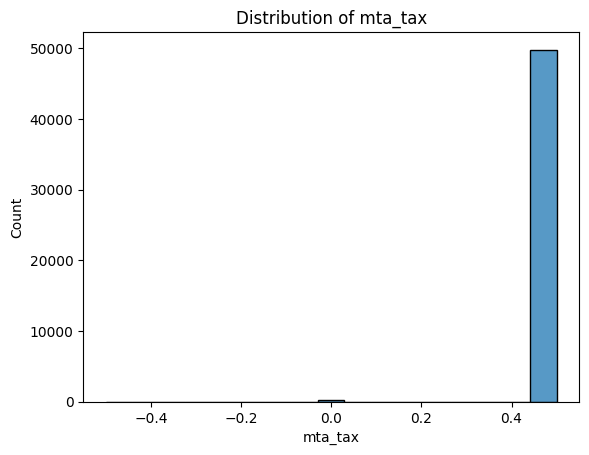

<Figure size 1000x600 with 0 Axes>

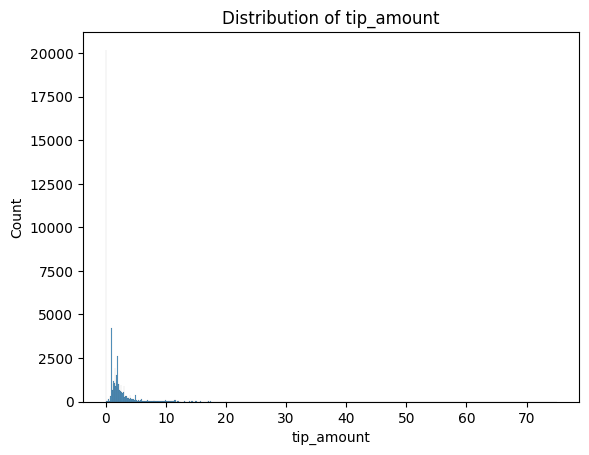

<Figure size 1000x600 with 0 Axes>

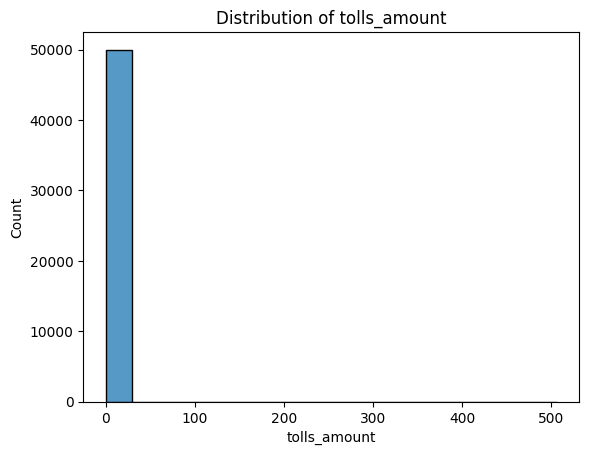

<Figure size 1000x600 with 0 Axes>

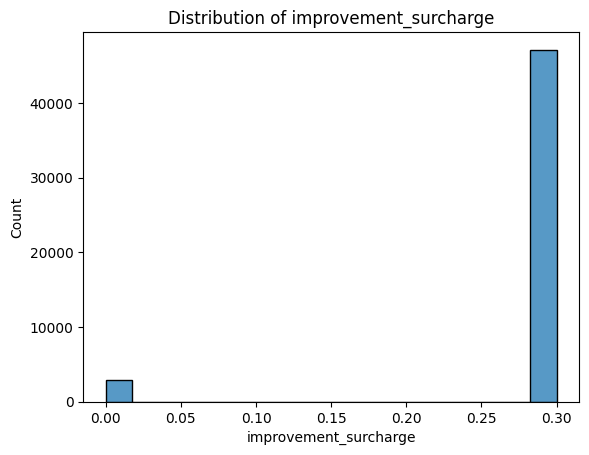

<Figure size 1000x600 with 0 Axes>

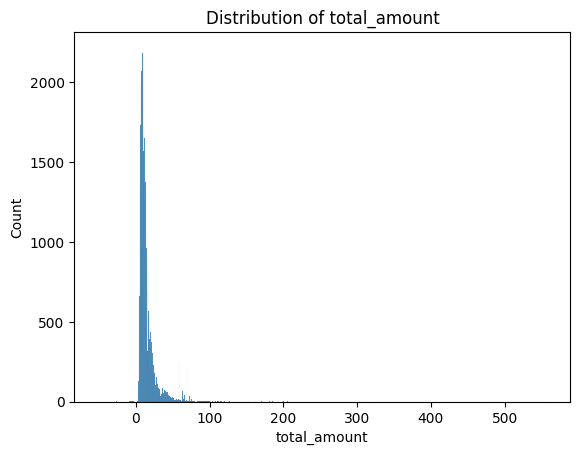

In [14]:

# Visualization of the distribution within a feature however it takes too much time as there is too much data
for x in univariate_analysis_values:
    plt.figure(figsize=(10,6))
    plt.figure()
    sns.histplot(rows[x])
    plt.title(f"Distribution of {x}")
    plt.show()


Thanks to the visualisations we can observe more into details the unbalanced classes

### store_and_fwd_flag

In [17]:
# Check the values of "store_and_fwd_flag"
df["store_and_fwd_flag"].value_counts()

store_and_fwd_flag
N    12633953
Y      115033
Name: count, dtype: int64

In [18]:
# One-hot encode 
df["store_and_fwd_flag"] = df["store_and_fwd_flag"].map(lambda x: 0 if x=='N' else 1)

# Verification 
df["store_and_fwd_flag"].value_counts()

store_and_fwd_flag
0    12633953
1      115033
Name: count, dtype: int64

### Passenger count

In [20]:
df['passenger_count'].value_counts()

passenger_count
1    8993870
2    1814594
5     697645
3     528486
6     454568
4     253228
0       6565
9         11
8         10
7          9
Name: count, dtype: int64

### RateCode ID

In [22]:
df['RateCodeID'].value_counts()

RateCodeID
1     12464898
2       224723
5        36896
3        17700
4         4128
99         507
6          134
Name: count, dtype: int64

### Payment type

In [24]:
df['payment_type'].value_counts()

payment_type
1    7881388
2    4816992
3      38632
4      11972
5          2
Name: count, dtype: int64

### MTA Tax

In [26]:
# See if mta_tax is constant
df['mta_tax'].value_counts()

mta_tax
 0.5    12696762
 0.0       48317
-0.5        3907
Name: count, dtype: int64

### improvement surcharge

In [28]:
df['improvement_surcharge'].value_counts()

improvement_surcharge
0.3    12032621
0.0      716362
Name: count, dtype: int64

### Boxplots

In [30]:
# Make a numerical and categorical columns list
univariate_analysis_values=[]
geographical_values=[]

geo_cols = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']
numerical_values = [x for x in df.columns if df[x].dtypes != object]

for x in numerical_values:
    if x in geo_cols:
        geographical_values.append(x)
    else:
        univariate_analysis_values.append(x)


<Figure size 1500x1500 with 0 Axes>

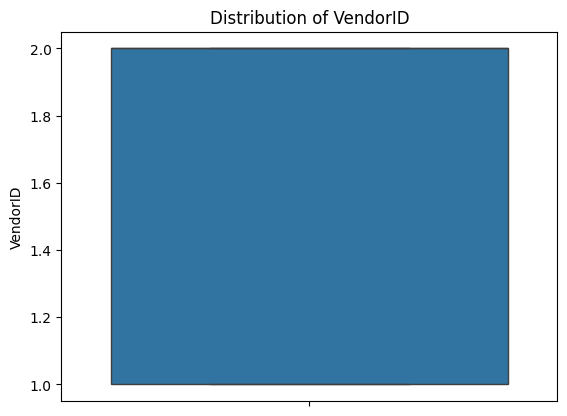

<Figure size 1500x1500 with 0 Axes>

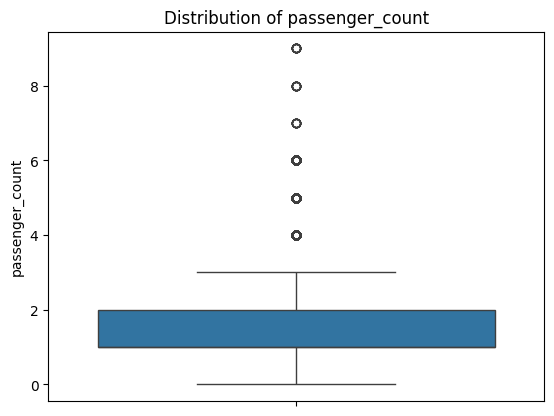

<Figure size 1500x1500 with 0 Axes>

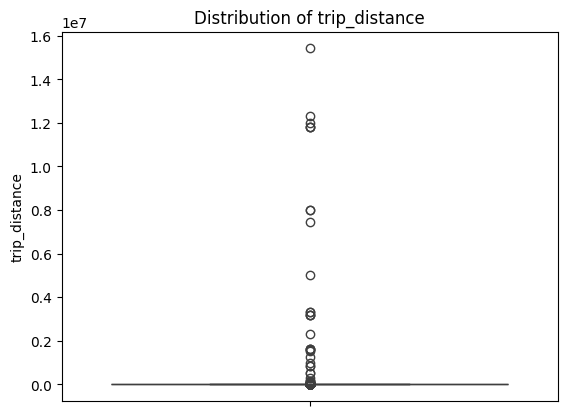

<Figure size 1500x1500 with 0 Axes>

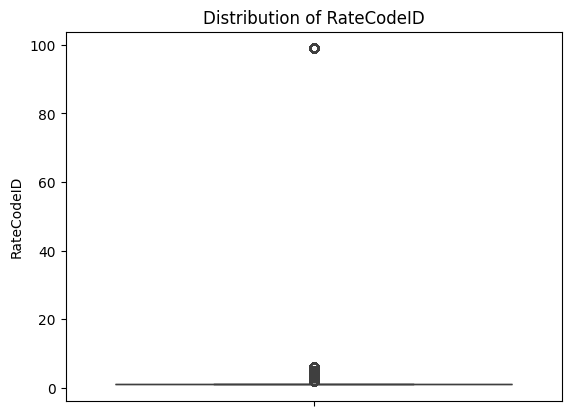

<Figure size 1500x1500 with 0 Axes>

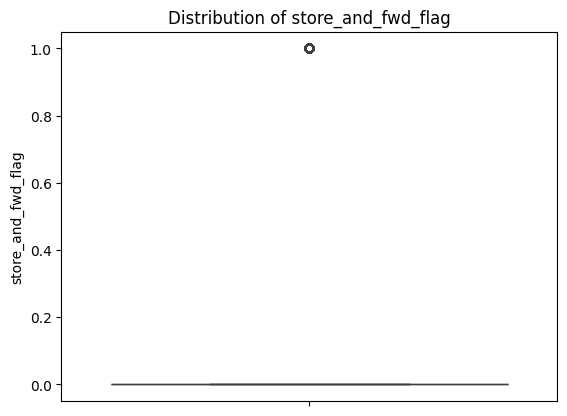

<Figure size 1500x1500 with 0 Axes>

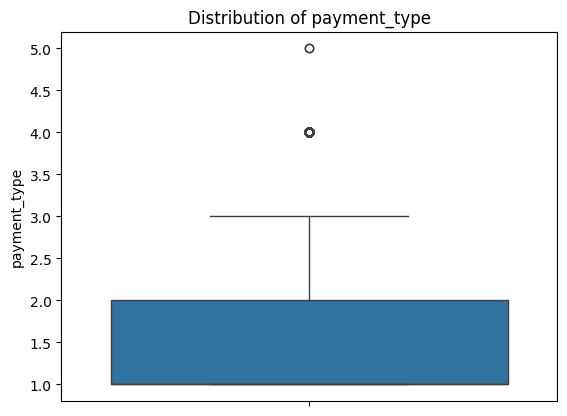

<Figure size 1500x1500 with 0 Axes>

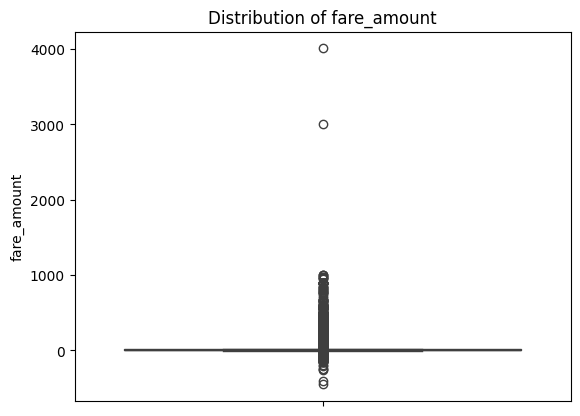

<Figure size 1500x1500 with 0 Axes>

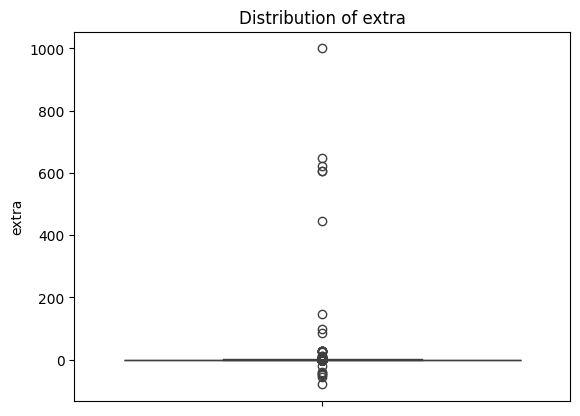

<Figure size 1500x1500 with 0 Axes>

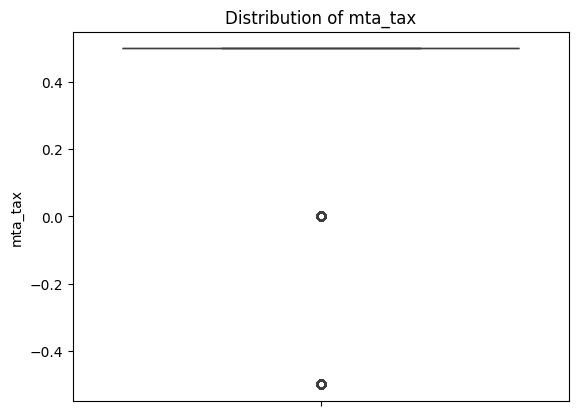

<Figure size 1500x1500 with 0 Axes>

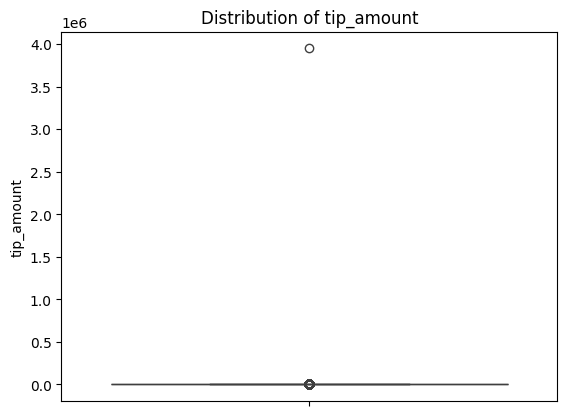

<Figure size 1500x1500 with 0 Axes>

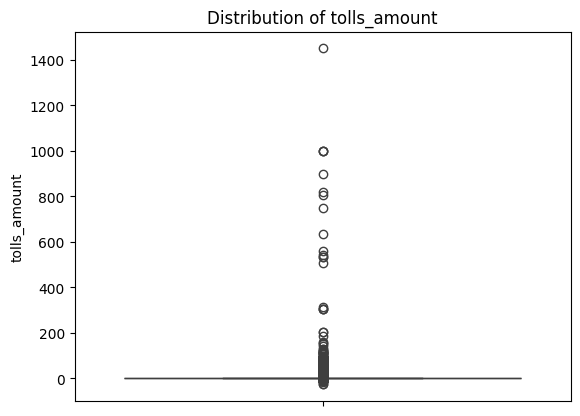

<Figure size 1500x1500 with 0 Axes>

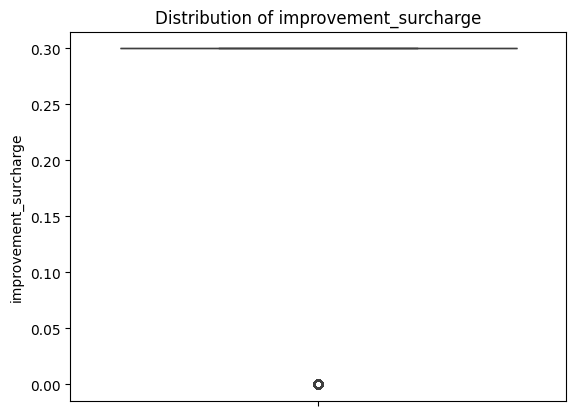

<Figure size 1500x1500 with 0 Axes>

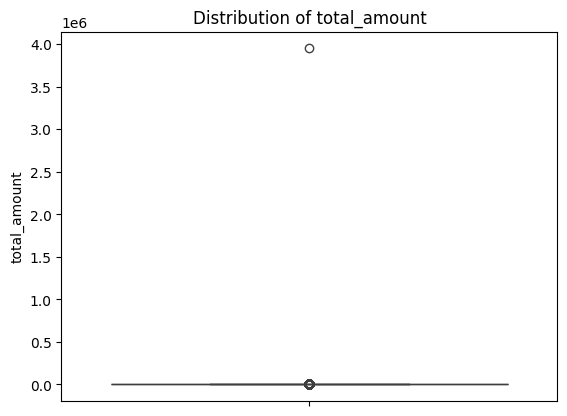

In [31]:

# Visualization of the boxplots
for x in univariate_analysis_values:
    plt.figure(figsize=(15,15))
    plt.figure()
    sns.boxplot(df[x])
    plt.title(f"Distribution of {x}")
    plt.show()


## Bivariate Analysis:

In [33]:
# Convert time to timestamps
format_code = "%Y-%m-%d %H:%M:%S"

df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'], format=format_code)
df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'], format=format_code)

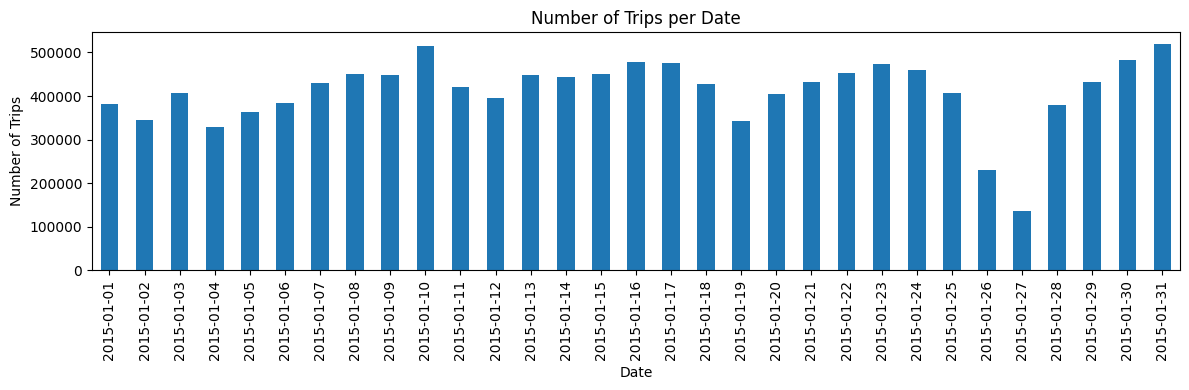

In [34]:
# Number of trips per date

df["pickup_date"] = df["tpep_pickup_datetime"].dt.date
trips_per_date = df.groupby("pickup_date").size()

trips_per_date.plot(kind="bar", figsize=(12,4))
plt.title("Number of Trips per Date")
plt.xlabel("Date")
plt.ylabel("Number of Trips")
plt.tight_layout()
plt.show()

Text(0, 0.5, 'Average Fare Amount')

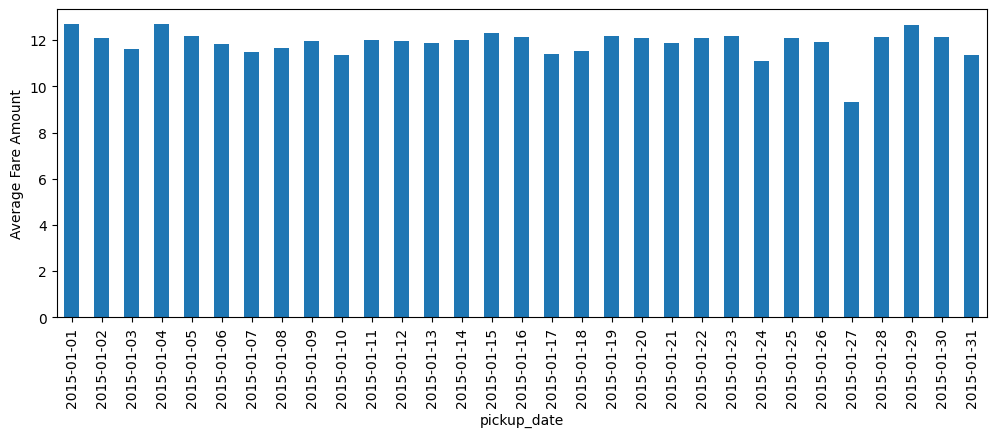

In [35]:
# Visualizue the average fare amount per day 
avg_fare_amount_per_day = df["fare_amount"].groupby(df["pickup_date"]).mean()
avg_fare_amount_per_day.plot(kind='bar', figsize=(12,4))
plt.ylabel('Average Fare Amount')

Text(0, 0.5, 'Avg Fare')

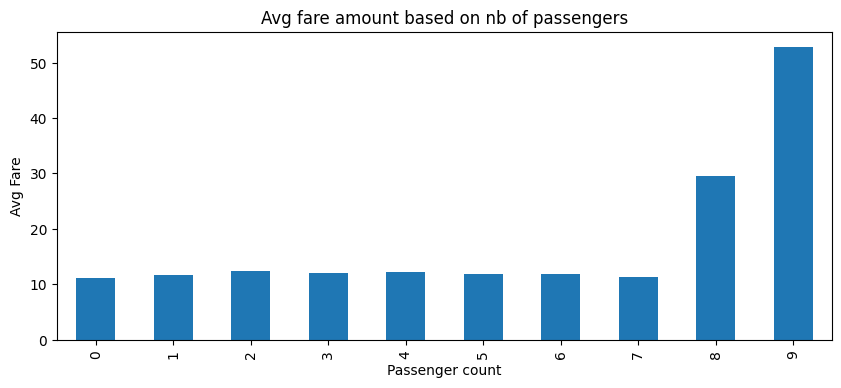

In [36]:
# Check if the price changes depending on the number of passengers
fare_by_passengers = df['fare_amount'].groupby(df['passenger_count']).mean()

plt.figure(figsize=(10,4))
fare_by_passengers.plot(kind='bar') 
plt.title('Avg fare amount based on nb of passengers')
plt.xlabel('Passenger count')
plt.ylabel('Avg Fare')

In [37]:
df['fare_amount'].groupby(df['store_and_fwd_flag']).mean()

store_and_fwd_flag
0    11.897706
1    12.779179
Name: fare_amount, dtype: float64

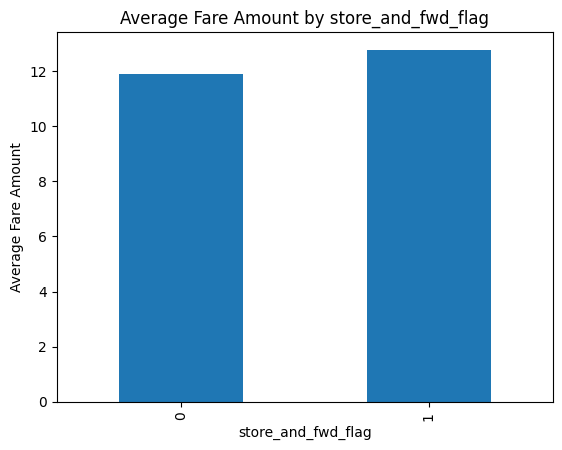

In [38]:
# See if store_and_fwd_flag affects fare_amount
sff_vs_fare = df['fare_amount'].groupby(df['store_and_fwd_flag']).mean()

# Plot
sff_vs_fare.plot(kind='bar')
plt.xlabel('store_and_fwd_flag')
plt.ylabel('Average Fare Amount')
plt.title('Average Fare Amount by store_and_fwd_flag')
plt.show()

Since both 0 & 1 seem to have the same impact on the fare we could potentially drop it

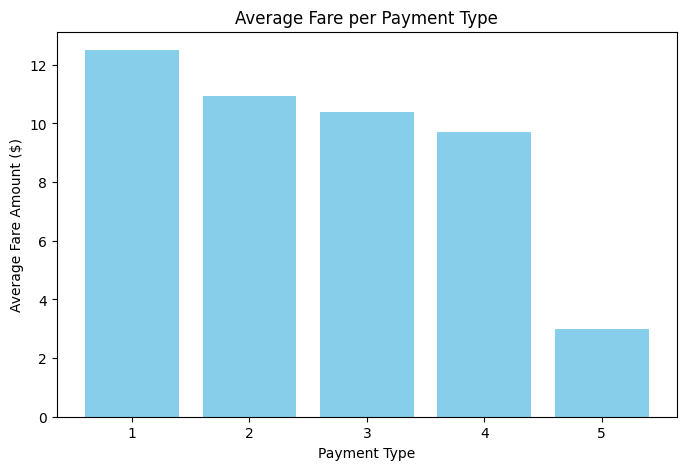

In [40]:
# Compute average fare per payment type
avg_fare = df.groupby('payment_type')['fare_amount'].mean().reset_index()

# Plot
plt.figure(figsize=(8,5))
plt.bar(avg_fare['payment_type'], avg_fare['fare_amount'], color='skyblue')
plt.xlabel('Payment Type')
plt.ylabel('Average Fare Amount ($)')
plt.title('Average Fare per Payment Type')
plt.xticks(rotation=0)
plt.show()


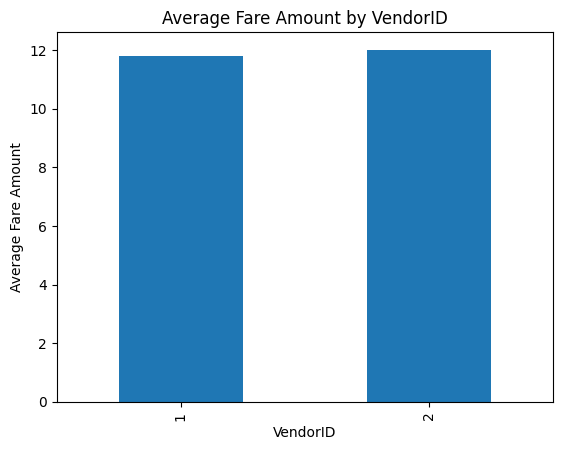

In [41]:
# See if VendorID really has an impact on the fare amount
vendorid_vs_fare = df['fare_amount'].groupby(df['VendorID']).mean()

# Plot
vendorid_vs_fare.plot(kind='bar')
plt.xlabel('VendorID')
plt.ylabel('Average Fare Amount')
plt.title('Average Fare Amount by VendorID')
plt.show()


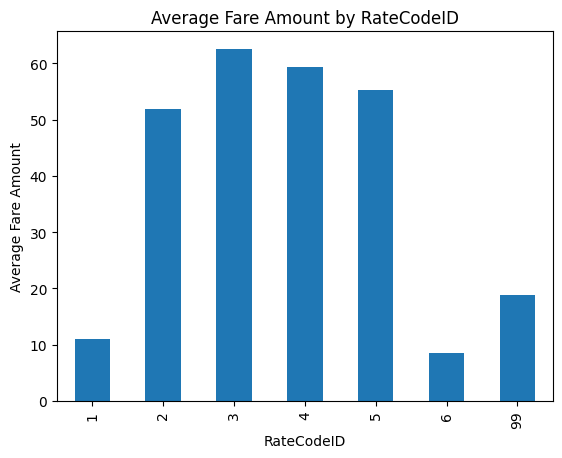

In [42]:
# See if RateCodeID affects fare amount
ratecodeid_vs_fare = df['fare_amount'].groupby(df['RateCodeID']).mean()

# Plot
ratecodeid_vs_fare.plot(kind='bar')
plt.xlabel('RateCodeID')
plt.ylabel('Average Fare Amount')
plt.title('Average Fare Amount by RateCodeID')
plt.show()

<Axes: >

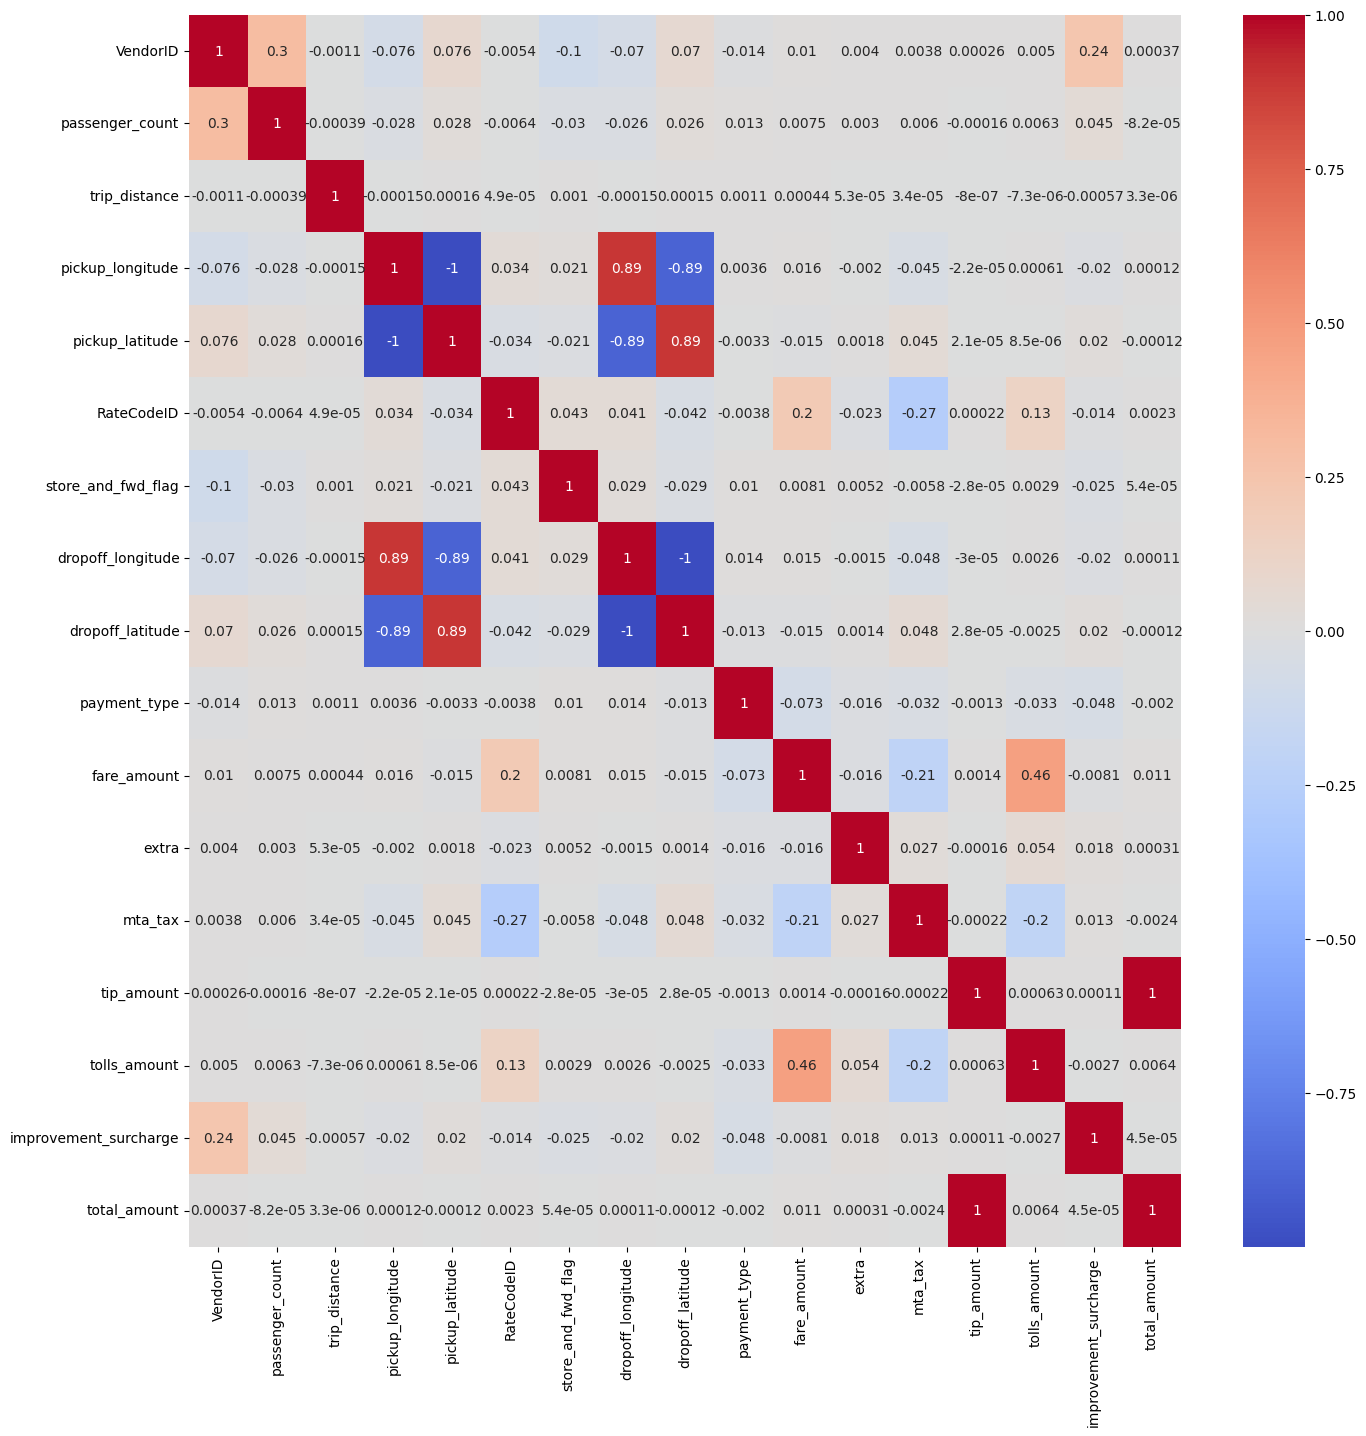

In [43]:
plt.figure(figsize=(16, 16))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm")

# Step 3: Clean the data

### 3.1) Drop Missing values
We have decided to drop instead of replace the missing values as there are only 3 out of 12M+ rows

In [46]:
df = df.dropna()

In [47]:
df.isnull().sum()

VendorID                 0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
pickup_longitude         0
pickup_latitude          0
RateCodeID               0
store_and_fwd_flag       0
dropoff_longitude        0
dropoff_latitude         0
payment_type             0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
total_amount             0
pickup_date              0
dtype: int64

### 3.2) Remove outliers

In [49]:
# Remove negative distances
df = df[df["trip_distance"] > 0]

In [50]:
df = df[df['fare_amount'] > 0 ]

In [51]:
df = df[df['passenger_count']>0]

In [52]:
def remove_outliers(df, column):
    Q1 = df[column].quantile(25/100)
    Q3 = df[column].quantile(75/100)
    IQR = Q3 - Q1
    
    lim_inf = Q1 - 1.5 * IQR
    lim_sup = Q3 + 1.5 * IQR
    
    df_clean = df[(df[column] >= lim_inf) & (df[column] <= lim_sup)]
    return df_clean

In [53]:
len(df)

12658407

### 3.3) Sample the DataFrame
Since our dataset has more than 12 million rows, we need break our DataFrame into smaller pieces so that we can train on it and then scale upwards

In [55]:
def sample_uniform_by_day(
    df: pd.DataFrame,
    datetime_col: str = "tpep_pickup_datetime",
    n_per_day: int | None = None,
    frac_per_day: float | None = None,
    random_state: int = 42
) -> pd.DataFrame:
    """
    Samples uniformly at random within each day.
- Choose either `n_per_day` (fixed number of rows per day) or `frac_per_day` (fraction per day).
- If `n_per_day` > size of a given day, take all rows from that day.
    """
    if (n_per_day is None) == (frac_per_day is None):
        raise ValueError("Spécifie exactement l'un de `n_per_day` ou `frac_per_day`.")

    # Make sure the time column is set to datetime
    df = df.copy()
    df[datetime_col] = pd.to_datetime(df[datetime_col], errors="coerce")
    df = df.dropna(subset=[datetime_col])

    # Key ‘date’ (calendar day) from the time of pick-up
    df["_date"] = df[datetime_col].dt.date

    if n_per_day is not None:
        # Sampling with a fixed number per day (without replacement)
        out = (
            df.groupby("_date", group_keys=False)
              .apply(lambda g: g.sample(n=min(n_per_day, len(g)),
                                        replace=False,
                                        random_state=random_state))
        )
    else:
         # Sampling with one fraction per day
        out = (
            df.groupby("_date", group_keys=False)
              .apply(lambda g: g.sample(frac=frac_per_day,
                                        replace=False,
                                        random_state=random_state))
        )

    return out.drop(columns=["_date"])

# Step 4: Feature Engineering

Text(0, 0.5, 'Average Fare')

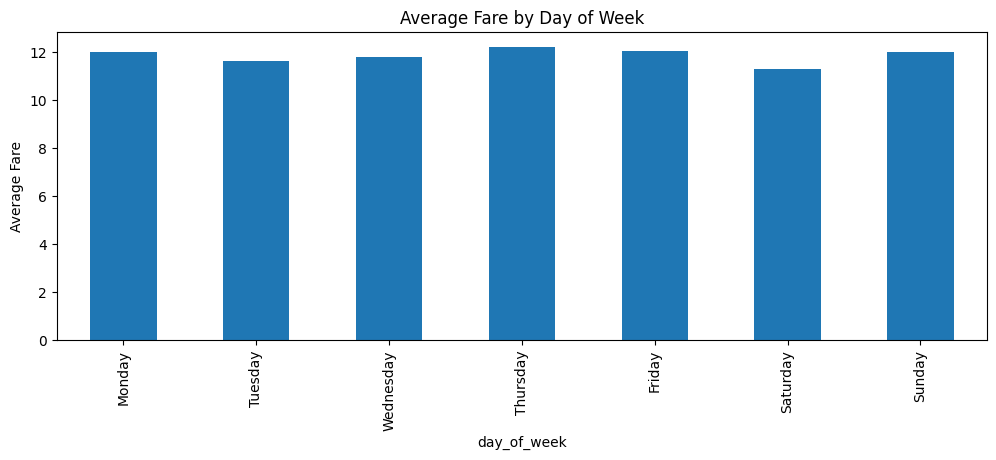

In [57]:
# Make 'pickup_date' to a datetime object
df['pickup_date'] = pd.to_datetime(df['pickup_date'], format=format_code)

# Extract the name of the day
df['day_of_week'] = df['pickup_date'].dt.day_name()

# Compute average fare per day of week
avg_fare_amount_per_day_of_week = (
    df.groupby('day_of_week')['fare_amount'].mean().reindex(
        ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    )
)

# Plot
avg_fare_amount_per_day_of_week.plot(kind='bar', figsize=(12, 4), title='Average Fare by Day of Week')

plt.ylabel('Average Fare')

In [58]:
# Check if midnight is 0 or 00
df['tpep_pickup_datetime'].dt.hour.min()

0

In [59]:
# Categorize the different moments of a day (early morning, morning, noon/afternoon, night)

def map_moments_of_day(x):
    if x.hour in range(0,6):
        return "early morning"
    elif x.hour in range(6, 13):
        return 'morning'
    elif x.hour in range(13, 16):
        return 'noon/afternoon'
    elif x.hour in range(16,21):
        return 'rush hour'
    else:
        return "night"

In [60]:
# Create a column moments of day
df['Moments_of_day'] = df['tpep_pickup_datetime'].apply(map_moments_of_day)

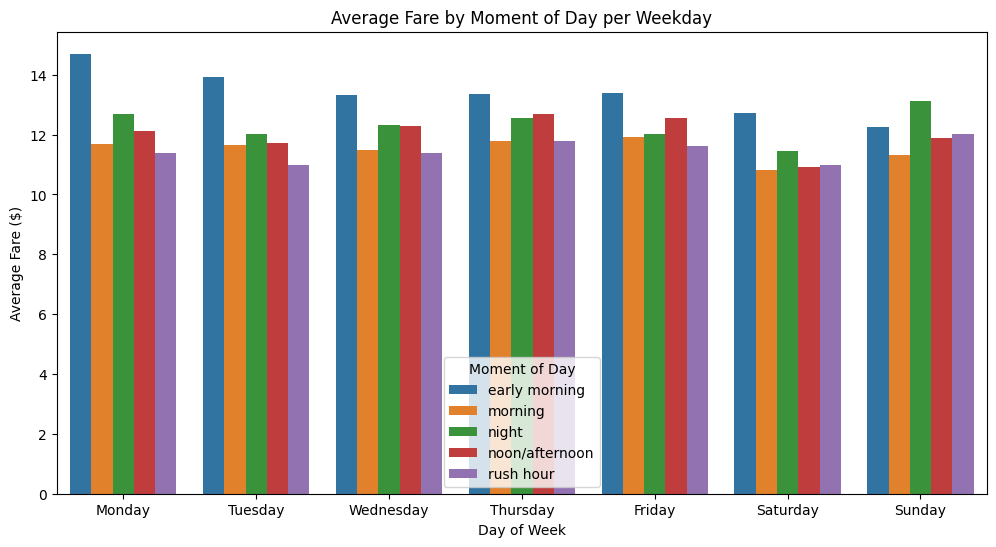

In [61]:
# Plot the average fare of the moments of the day per day of 

# Aggregate fare_amount mean by the day of the week and the moment of the day 
avg_fare = df.groupby(['day_of_week', 'Moments_of_day'], observed=False)['fare_amount'].mean().reset_index()

plt.figure(figsize=(12, 6))

sns.barplot(
    data=avg_fare,
    x='day_of_week',
    y='fare_amount',
    hue='Moments_of_day',
    order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'] # For a more comprehensible visualisation
)

plt.title('Average Fare by Moment of Day per Weekday')
plt.ylabel('Average Fare ($)')
plt.xlabel('Day of Week')
plt.legend(title='Moment of Day')
plt.show()

<Axes: xlabel='day_of_week', ylabel='fare_amount'>

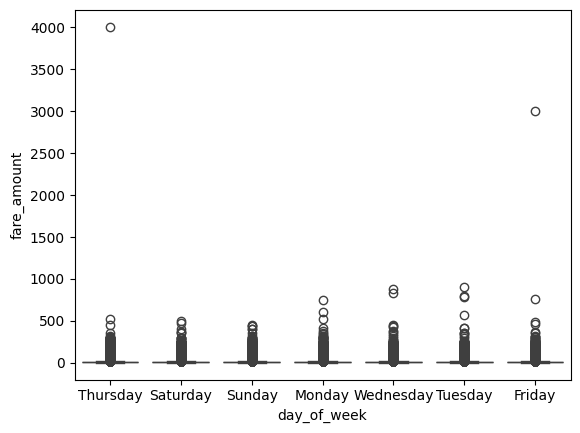

In [62]:
# Look at the distributions of the fares per day
sns.boxplot(x='day_of_week', y='fare_amount', data=df)

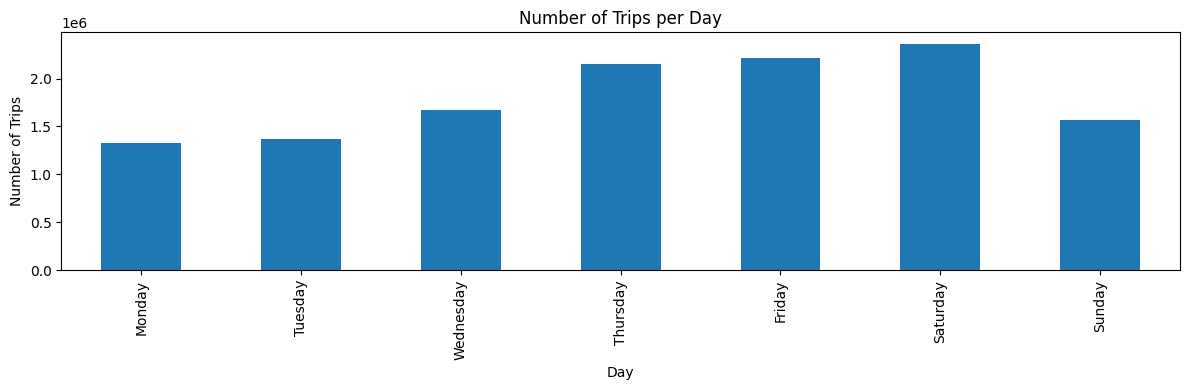

In [63]:
# Define the correct order
ordered_days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

# Convert to an ordered categorical
df["day_of_week"] = pd.Categorical(df["day_of_week"], categories=ordered_days, ordered=True)

# Now group and plot again
trips_per_day = df.groupby('day_of_week', observed=False).size()

trips_per_day.plot(kind="bar", figsize=(12,4))
plt.title("Number of Trips per Day")
plt.xlabel("Day")
plt.ylabel("Number of Trips")
plt.tight_layout()
plt.show()


In [64]:
# Create time duration feature
df['duration_in_min'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.total_seconds() / 60

In [65]:
# Create average speed (mph) feature
df["avg_speed"] = 60*(df["trip_distance"]/df["duration_in_min"]) #in mph

In [66]:
#!pip install geopy

In [67]:
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

def find_clusters_kmeans(df, lon_col, lat_col, new_cluster_col, n_clusters=100):
    print(f"Clustering de '{new_cluster_col}' en {n_clusters} zones...")
    
    
    coords_df = df[[lon_col, lat_col]].dropna()
    coords_np = coords_df.values
    
    # Training Step
    kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=42, batch_size=2048, n_init='auto')
    kmeans.fit(coords_np)
    
    
    labels = kmeans.predict(coords_np)
    
    df_clustered = df.copy()
    df_clustered[new_cluster_col] = -1
    df_clustered.loc[coords_df.index, new_cluster_col] = labels
    df_clustered[new_cluster_col] = df_clustered[new_cluster_col].astype(int)
    

    return df_clustered, kmeans


# Clustering 
df, pickup_model = find_clusters_kmeans(
    df, 
    'pickup_longitude', 'pickup_latitude', 
    'Pickup_Cluster', 
    n_clusters=100
)


coords_dropoff = df[['dropoff_longitude', 'dropoff_latitude']].dropna()
labels_dropoff = pickup_model.predict(coords_dropoff.values)

df['Dropoff_Cluster'] = -1
df.loc[coords_dropoff.index, 'Dropoff_Cluster'] = labels_dropoff
df['Dropoff_Cluster'] = df['Dropoff_Cluster'].astype(int)

print("Clustering Done!")

# GEO API 

from geopy.exc import GeocoderTimedOut, GeocoderUnavailable


geolocator = Nominatim(user_agent="nyc_taxi_project_student_final_v3", timeout=5)
geocode = RateLimiter(geolocator.reverse, min_delay_seconds=1.5)

cluster_centers = pickup_model.cluster_centers_ 
cluster_names = {}

for cluster_id, coords in enumerate(cluster_centers):
    lon, lat = coords 
    
    
    lat = float(lat)
    lon = float(lon)

    try:
        location = geocode((lat, lon), language='en')
        
        if location:
            address = location.raw.get('address', {})
            neigh = address.get('neighbourhood', address.get('hamlet', address.get('quarter', 'Unknown')))
            borough = address.get('suburb', address.get('city_district', address.get('borough', 'Unknown')))
            cluster_names[cluster_id] = {'Neighbourhood': neigh, 'Borough': borough}
        else:
            cluster_names[cluster_id] = {'Neighbourhood': 'Unknown', 'Borough': 'Unknown'}
            
    except (GeocoderTimedOut, GeocoderUnavailable):
    
        
        cluster_names[cluster_id] = {'Neighbourhood': 'Error', 'Borough': 'Error'}
    except Exception as e:
        cluster_names[cluster_id] = {'Neighbourhood': 'Error', 'Borough': 'Error'}
        
    if cluster_id % 10 == 0: 
        print(f"  - Zone {cluster_id}/100 traitée...")
        continue


print("Fusion des noms dans le DataFrame...")
df_zones = pd.DataFrame.from_dict(cluster_names, orient='index').reset_index()
df_zones.columns = ['Cluster_ID', 'Neighbourhood', 'Borough']

#Now adjusting pickup and dropoff columns using actual locations based on coords
df = df.merge(
    df_zones.rename(columns={'Cluster_ID': 'Pickup_Cluster', 'Neighbourhood': 'Pickup_Neighbourhood', 'Borough': 'Pickup_Borough'}),
    on='Pickup_Cluster', how='left'
)

df = df.merge(
    df_zones.rename(columns={'Cluster_ID': 'Dropoff_Cluster', 'Neighbourhood': 'Dropoff_Neighbourhood', 'Borough': 'Dropoff_Borough'}),
    on='Dropoff_Cluster', how='left'
)
print("Done")

Clustering de 'Pickup_Cluster' en 100 zones...
Clustering Done!
  - Zone 0/100 traitée...
  - Zone 10/100 traitée...
  - Zone 20/100 traitée...
  - Zone 30/100 traitée...
  - Zone 40/100 traitée...
  - Zone 50/100 traitée...
  - Zone 60/100 traitée...
  - Zone 70/100 traitée...
  - Zone 80/100 traitée...
  - Zone 90/100 traitée...
Fusion des noms dans le DataFrame...
Done


In [68]:
df

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,...,day_of_week,Moments_of_day,duration_in_min,avg_speed,Pickup_Cluster,Dropoff_Cluster,Pickup_Neighbourhood,Pickup_Borough,Dropoff_Neighbourhood,Dropoff_Borough
0,2,2015-01-15 19:05:39,2015-01-15 19:23:42,1,1.59,-73.993896,40.750111,1,0,-73.974785,...,Thursday,rush hour,18.050000,5.285319,62,34,Chelsea District,Manhattan,Tudor City,Manhattan
1,1,2015-01-10 20:33:38,2015-01-10 20:53:28,1,3.30,-74.001648,40.724243,1,0,-73.994415,...,Saturday,rush hour,19.833333,9.983193,11,91,SoHo,Manhattan,Manhattan Community Board 4,Manhattan
2,1,2015-01-10 20:33:38,2015-01-10 20:43:41,1,1.80,-73.963341,40.802788,1,0,-73.951820,...,Saturday,rush hour,10.050000,10.746269,64,81,Manhattan Valley,Manhattan,Manhattan Community Board 10,Manhattan
3,1,2015-01-10 20:33:39,2015-01-10 20:35:31,1,0.50,-74.009087,40.713818,1,0,-74.004326,...,Saturday,rush hour,1.866667,16.071429,26,74,Tribeca,Manhattan,Hudson Square,Manhattan
4,1,2015-01-10 20:33:39,2015-01-10 20:52:58,1,3.00,-73.971176,40.762428,1,0,-74.004181,...,Saturday,rush hour,19.316667,9.318378,41,0,Manhattan Community Board 5,Manhattan,Chelsea District,Manhattan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12658402,1,2015-01-10 19:01:44,2015-01-10 19:05:40,2,1.00,-73.951988,40.786217,1,0,-73.953735,...,Saturday,rush hour,3.933333,15.254237,31,3,Carnegie Hill,Manhattan,Yorkville,Manhattan
12658403,1,2015-01-10 19:01:44,2015-01-10 19:07:26,2,0.80,-73.982742,40.728184,1,0,-73.974976,...,Saturday,rush hour,5.700000,8.421053,48,37,East Village,Manhattan,Alphabet City,Manhattan
12658404,1,2015-01-10 19:01:44,2015-01-10 19:15:01,1,3.40,-73.979324,40.749550,1,0,-73.969101,...,Saturday,rush hour,13.283333,15.357591,65,99,Manhattan Community Board 5,Manhattan,Manhattan Community Board 7,Manhattan
12658405,1,2015-01-10 19:01:44,2015-01-10 19:17:03,1,1.30,-73.999565,40.738483,1,0,-73.981819,...,Saturday,rush hour,15.316667,5.092492,72,93,Union Square,Manhattan,Gramercy,Manhattan
